# Mapk Counterfactual Inference

In [1]:
import sys
sys.path.append('../')

import pyro
from pyro import sample
from pyro.distributions import Normal, Uniform
import torch
from torch.distributions import constraints
from tqdm import tqdm_notebook as tqdm
import pyro.optim

from pyro.infer.mcmc import MCMC
from pyro.infer.mcmc.nuts import NUTS, HMC
from pyro.infer import EmpiricalMarginal

from mapk_demon.inference import infer_dist
from mapk_demon.receivers import mapk_receiver

import matplotlib.pyplot as plt
%matplotlib inline

pyro.set_rng_seed(101)
sample_size = 1000

def hist(marginal, name):
    plt.hist([marginal() for _ in range(5000)])
    plt.title("Marginal Histogram of {}".format(name))
    plt.xlabel("concentration")
    plt.ylabel("#")

In [6]:
noise_vars = ['N_3k', 'N_2k', 'N_k']
noise_dists = {N: Normal(10., 1.) for N in noise_vars}

mapk_receiver(noise_dists)

{'map2k': tensor(12.1773), 'map3k': tensor(11.9624), 'mapk': tensor(1.3070)}

## 1. Condition the model on observed map3k, map2k, mapk

In [7]:
conditioned_mapk = pyro.condition(mapk_receiver, data={'map2k': 13.8113, 'map3k': 11.0504, 'mapk': 0.2803})

## 2. Infer the noise distributions N_3k, N_2k, N_k

In [8]:
noise_priors = {N: Normal(0., 1.) for N in noise_vars}

posterior = infer_dist(conditioned_mapk, noise_priors)

noise_marginals = {
    n: EmpiricalMarginal(posterior, sites=n)
    for n in noise_vars
}

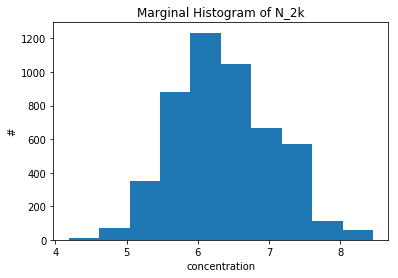

In [9]:
hist(noise_marginals['N_2k'], 'N_2k')

## 3. do Map3k = 5.678

In [21]:
do_map3k = pyro.do(mapk_receiver, data={'map3k': 5.678})

## 4. Infer Mapk

In [22]:
mapk_do_dist = infer_dist(do_map3k, noise_marginals)
mapk_marginal = EmpiricalMarginal(mapk_do_dist, sites = 'mapk')

RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.